# AUTOENCODER WITH EFFICIENT-NET

<font size='6'>Anggota :</font>
<font size='5'>
<br>Andreas Mardohar Kristianto - 2602100096 
<br>Gabriel Enrico - 2602105481 
<br>Alexander Prajna Felipe - 2602097403
<br>Muhammad Bagier Asseggaf - 2602134531
</p>
<br>We provided code and annotation for each steps
<br>To find more about documentation, implementation and demo please visit :
<br>
<a href="https://github.com/AndreasKrist/ImageReconstructionEffecientNet">github.com/AndreasKrist/ImageReconstructionEffecientNet</a>
</font>

In [10]:
#Import Libary for this project
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Auto Encoder Class
class AdvancedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        efficientnet = models.efficientnet_b0(weights='DEFAULT') # We use EfficientNet as the encoder
        self.encoder = nn.Sequential(*list(efficientnet.features))
        # Decoder with ConvTranspose2d layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, 4, 2, 1), # Upsample from 1280 channels to 512
            nn.InstanceNorm2d(512), # Normalize the feature maps
            nn.LeakyReLU(0.2), # Activation function for non-linearity
            nn.Dropout(0.3), # Dropout
            nn.ConvTranspose2d(512, 256, 4, 2, 1), #upsample to 256 channels
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), #upsample to 128 channels
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), #upsample to 64 channels
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), # upsample to 3 channels (RGB image)
            nn.Tanh() # Activation function to scale the output [-1, 1]
        )

    def forward(self, x):
        # Passing input through the encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
# calculate the pixel-level accuracy
# Mean Squared Error (MSE) is used to Measures how close the reconstructed image is to the input

def calculate_accuracy(input_tensor, output_tensor):
    mse = nn.functional.mse_loss(input_tensor, output_tensor, reduction='none')
    pixel_accuracy = 1 - mse.mean(dim=(1, 2, 3))
    return pixel_accuracy.mean().item()

In [4]:
# Training function
def train():

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use GPU for training
    
    # Preprocessing (resize, crop, normalize)
    transform = transforms.Compose([
        transforms.Resize(224), # Resize to 224x224
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
    
    # automatically downloaded and load Food-101 dataset
    dataset = datasets.Food101(root='./data', split='train', transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)
    
    model = AdvancedAutoencoder().to(device)
    criterion = nn.MSELoss() # loss function (Mean Squared Error)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01) #optimizer (AdamW)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10) #Learning rate scheduler for cosine annealing

    # The training parameters
    epochs = 10
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_accuracy = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data) # Forward pass
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() # Accumulate the loss
            
            # Calculate the accuracy 
            accuracy = calculate_accuracy(data, output)
            total_accuracy += accuracy
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
        
        scheduler.step() # Update learning rate scheduler

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(dataloader)
        avg_accuracy = total_accuracy / len(dataloader)
        losses.append(avg_loss)
        accuracies.append(avg_accuracy)

        # Print epoch progress
        print(f'Epoch {epoch} - Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}')
        torch.save(model.state_dict(), f'autoencoder_epoch_{epoch}.pth')
    
    # Plot loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='orange')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch: 0, Batch: 0, Loss: 1.7273, Accuracy: -0.7273
Epoch: 0, Batch: 100, Loss: 0.9854, Accuracy: 0.0146
Epoch: 0, Batch: 200, Loss: 0.9549, Accuracy: 0.0451
Epoch: 0, Batch: 300, Loss: 0.6420, Accuracy: 0.3580
Epoch: 0, Batch: 400, Loss: 0.6954, Accuracy: 0.3046
Epoch: 0, Batch: 500, Loss: 0.6078, Accuracy: 0.3922
Epoch: 0, Batch: 600, Loss: 0.5144, Accuracy: 0.4856
Epoch: 0, Batch: 700, Loss: 0.4991, Accuracy: 0.5009
Epoch: 0, Batch: 800, Loss: 0.5709, Accuracy: 0.4291
Epoch: 0, Batch: 900, Loss: 0.5225, Accuracy: 0.4775
Epoch: 0, Batch: 1000, Loss: 0.4942, Accuracy: 0.5058
Epoch: 0, Batch: 1100, Loss: 0.5868, Accuracy: 0.4132
Epoch: 0, Batch: 1200, Loss: 0.5232, Accuracy: 0.4768
Epoch: 0, Batch: 1300, Loss: 0.5032, Accuracy: 0.4968
Epoch: 0, Batch: 1400, Loss: 0.4478, Accuracy: 0.5522
Epoch: 0, Batch: 1500, Loss: 0.5585, Accuracy: 0.4415
Epoch: 0, Batch: 1600, Loss: 0.5131, Accuracy: 0.4869
Epoch: 0, Batch: 1700, Loss: 0.4532, Accuracy: 0.5468
Epoch: 0, Batch: 1800, Loss: 0.3866, Ac

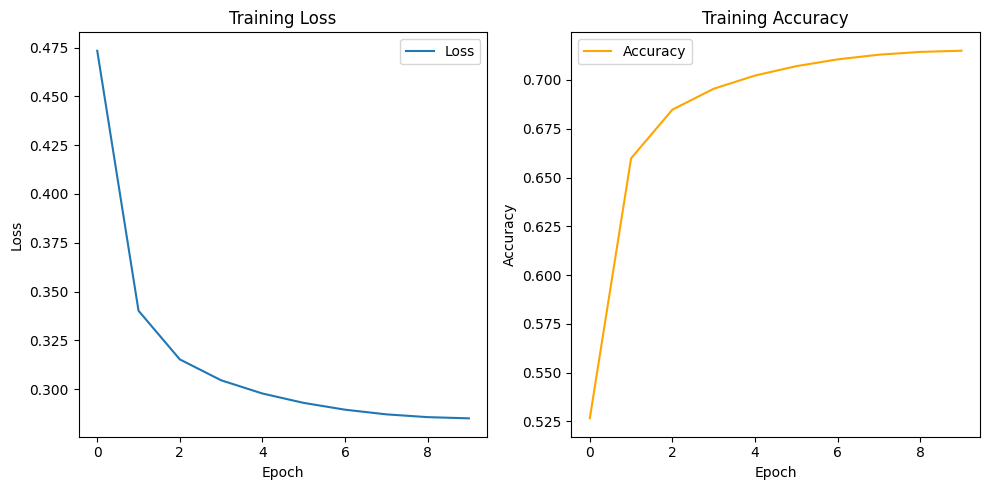

In [9]:
# Train the model and show the metrics plot
train()

### Validation metrics and plot reconstructed images

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Validation 
#almost same code as training but for validation
transform = transforms.Compose([
    transforms.Resize(224),  
    transforms.CenterCrop(224),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Load the validation dataset 
validation_dataset = datasets.Food101(root='./data', split='test', transform=transform, download=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)

# Initialize the model and load the saved state dict
model = AdvancedAutoencoder().to(device)
model.load_state_dict(torch.load('autoencoder_epoch_9.pth'))  #Trained Model
model.eval() 

# Loss function
criterion = nn.MSELoss()

# Evaluate on validation dataset
total_val_loss = 0
total_val_accuracy = 0

with torch.no_grad():  
    for batch_idx, (data, _) in enumerate(validation_loader):
        data = data.to(device) 
        output = model(data)
        loss = criterion(output, data) 
        total_val_loss += loss.item()
        
        # Calculate the 
        accuracy = calculate_accuracy(data, output)
        total_val_accuracy += accuracy

# Calculate average loss and accuracy
avg_val_loss = total_val_loss / len(validation_loader)
avg_val_accuracy = total_val_accuracy / len(validation_loader)

print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}')


C:\Users\andre\AppData\Local\Temp\ipykernel_26116\290209514.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('autoencoder_epoch_9.pth'))

Validation Loss: 0.2677, Validation Accuracy: 0.7323


<font size='6'>Validation Loss: 0.2677, Validation Accuracy: 0.7323</font>
<br>Relatively compared to their training metrics



In [11]:
# Visualize original and reconstructed images
def visualize_reconstructions(model, dataloader, device):
    model.eval() 
    data_iter = iter(dataloader)
    images, _ = next(data_iter) 
    images = images.to(device)
    
    with torch.no_grad():
        reconstructed = model(images) 

    
    def unnormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
        return tensor * std + mean

    images = unnormalize(images).cpu().numpy().transpose(0, 2, 3, 1)
    reconstructed = unnormalize(reconstructed).cpu().numpy().transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(2, 8, figsize=(15, 5))
    for i in range(8):
        axes[0, i].imshow(np.clip(images[i], 0, 1))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(np.clip(reconstructed[i], 0, 1))
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

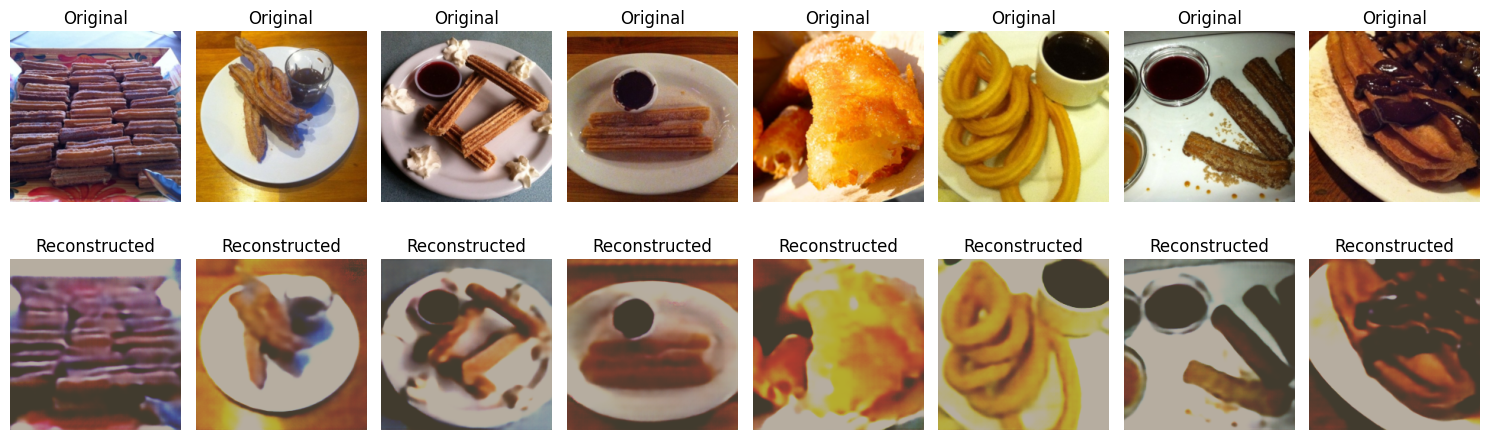

In [ ]:
# Show the plot images
validation_dataset = datasets.Food101(root='./data', split='test', transform=transform, download=True) # we use test as validation because food101 only provide 75% training and 25% testing
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)
visualize_reconstructions(model, validation_loader, device)